# 2-agent pacman 

## Oleksandr Hrabar

In this project we'll try to solve the **2 agent pacman problem** using two uninformed search algorithms named bfs and ids; and an informed search algorithm called A*.

## Initializations
Adding necessary libraries

In [ ]:
import collections
import copy
import math

Defining constants:

In [ ]:
P_MAN = 'P'
Q_MAN = 'Q'
WALL = '%'
P_FOOD = '1'
Q_FOOD = '2'
B_FOOD = '3'
EMPTY = ' '
FILENAME = 'test2'

## Helper Functions

### Read map
The function below reads the map from file and returns a 2d list containing map characters.

In [ ]:
def read_map(filename):
    file = open(filename)
    input_map = []
    
    for line in file:
        if line[-1] == '\n':
            input_map.append(list(line[:-1]))
        else:
            input_map.append(list(line))
    
    return input_map

Reading input map globally:

In [ ]:
input_map = read_map(FILENAME)

### Get pacmans locations
Following function returns the location of specified pacman as a tuple of x, y location.

In [ ]:
def get_man_location(man):
    for i, line in enumerate(input_map):
        for j, char in enumerate(line):
            if char == man:
                return (i, j)

### Get foods locations
We use the function below which returns foods of specified type as a list of tuples representing x, y locations.

In [ ]:
def get_foods_location(food):
    foods = []
    for i, line in enumerate(input_map):
        for j, char in enumerate(line):
            if char == food:
                foods.append((i, j))
    return foods

### Print state branch
Following functions are used to print changes on map on each action utill the given state is reached.

In [ ]:
def get_state_map(state):
    state_map = [ [' '] * len(input_map[0]) for _ in range(len(input_map))]
    
    state_map[state.p_man[0]][state.p_man[1]] = P_MAN
    state_map[state.q_man[0]][state.q_man[1]] = Q_MAN
    
    for food in state.p_foods:
        state_map[food[0]][food[1]] = P_FOOD
        
    for food in state.q_foods:
        state_map[food[0]][food[1]] = Q_FOOD

    for food in state.b_foods:
        state_map[food[0]][food[1]] = B_FOOD   
        
    for i, line in enumerate(input_map):
        for j, char in enumerate(line):
            if char == WALL:
                state_map[i][j] = WALL
    
    return state_map

In [ ]:
def print_state_map(state_map):
    for line in state_map:
        print(''.join(line))

In [ ]:
def print_state_branch(state):
    s = collections.deque()
    
    while state:
        s.append(state)
        state = state.parent
        
    while s:
        state = s.pop()
        state_map = get_state_map(state)
        print_state_map(state_map)
        print('-' * 25)

### Show state results

The function below is used to show some details about the goal state including state depth, states count and unique states count.

In [ ]:
def finalize(state, states_count, uniques_count):
    print("Depth: %s" % state.depth)
    print("States Count: %s" % states_count)
    print("Unique States Count: %d" % uniques_count)

## Search Characteristic
The problem is modeled to a search problem using the following components:

### States
States of this problem consist os locations of current P and Q pacmans and foods on map. The implementation of State class is shown below:

In [ ]:
class State:
    def __init__(self, parent, depth, p_man, q_man, p_foods, q_foods, b_foods):
        self.parent = parent
        self.depth = depth
        self.p_man = p_man
        self.q_man = q_man
        self.p_foods = p_foods
        self.q_foods = q_foods
        self.b_foods = b_foods
        
    def __eq__(self, other):
        return (self.p_man == other.p_man and
                self.q_man == other.q_man and
                self.p_foods == other.p_foods and
                self.q_foods == other.q_foods and
                self.b_foods == other.b_foods)
    
    def __lt__(self, other):
        return self.depth + get_heuristic(self) < other.depth + get_heuristic(other)
    
    def __hash__(self):
        return hash((self.p_man, self.q_man, str(self.p_foods), str(self.q_foods), str(self.b_foods)))
    
    def get_child(self):
        new_p_man = copy.deepcopy(self.p_man)
        new_q_man = copy.deepcopy(self.q_man)
        new_p_foods = copy.deepcopy(self.p_foods)
        new_q_foods = copy.deepcopy(self.q_foods)
        new_b_foods = copy.deepcopy(self.b_foods)
        
        return State(self, self.depth + 1, new_p_man, new_q_man, new_p_foods, new_q_foods, new_b_foods)

`p_man` represents **P** pacman location, `q_man` represents **Q** pacman location and `p_foods`, `q_foods`, `b_foods` represent locations of legal foods for **P** pacman, **Q** pacman and both pacmans respectively.

Some node specifications are also stored on State class to speed up the program which are `parent` which indicates creator (parent) of the current state and `depth` which indicates depth of the reaching state in state space tree.


Functions `__eq__` and `__hash__` use pacmans and foods locations to distinguish between different states.

`__lt__` function is used to calculate the f(n) function of node n in the A* search algorithm.

Function `get_child` is used to get a child state of calling state with parent equal to calling state and depth equal to calling state's depth + 1 and other variables equal to parent.

### Initial State
The first state consists of initial locations of pacmans and foods in map. The following function is used to create initial state.

In [ ]:
def create_initial_state():
    depth = 0
    parent = None
    p_man = get_man_location(P_MAN)
    q_man = get_man_location(Q_MAN)
    p_foods = get_foods_location(P_FOOD)
    q_foods = get_foods_location(Q_FOOD)
    b_foods = get_foods_location(B_FOOD)
    
    return State(parent, depth, p_man, q_man, p_foods, q_foods, b_foods)

### Actions
For each pacman there are 4 available actions which means there are totally 8 actions.

On each action one of the pacmans moves in up or right or down or left direction, then if there is legal pacman's food which are **1**, **3** for **P** pacman and **2**, **3** for **Q** pacman in the new position, agent eats the food and returns the new state, otherwise if there is illegal food or wall or other pacman in new location, action returns failure.

The implementation of action functions are shown below. on each action function call, a new location for moving pacman is calculated. If the new location is verified by `validate_new_location` function, `apply_action` function will be called to get a new state based on the new position. At the end, new state is returned if it's validated otherwise None is returned.

In [ ]:

def action_right(state, man):
    new_x = None
    new_y = None
    
    if(man == P_MAN):
        new_x = state.p_man[0]+1
        new_y = state.p_man[1]
    elif(man == Q_MAN):
        new_x = state.q_man[0]+1
        new_y = state.q_man[1]
    
    if validate_new_location(state, man, new_x, new_y):
        new_state = state.get_child()
        new_state = apply_action(new_state, man, new_x, new_y)
        return new_state
    else:
        return None

In [ ]:
def action_up(state, man):
    new_x = None
    new_y = None
    
    if(man == P_MAN):
        new_x = state.p_man[0]
        new_y = state.p_man[1]+1
    elif(man == Q_MAN):
        new_x = state.q_man[0]
        new_y = state.q_man[1]+1
    if validate_new_location(state, man, new_x, new_y):
        new_state = state.get_child()
        new_state = apply_action(new_state, man, new_x, new_y)
        return new_state
    else:
        return None

In [ ]:
def action_down(state, man):
    new_x = None
    new_y = None
    
    if(man == P_MAN):
        new_x = state.p_man[0]
        new_y = state.p_man[1]-1
    elif(man == Q_MAN):
        new_x = state.q_man[0]
        new_y = state.q_man[1]-1
    if validate_new_location(state, man, new_x, new_y):
        new_state = state.get_child()
        new_state = apply_action(new_state, man, new_x, new_y)
        return new_state
    else:
        return None

In [ ]:
def action_left(state, man):
    new_x = None
    new_y = None
    
    if(man == P_MAN):
        new_x = state.p_man[0]-1
        new_y = state.p_man[1]
    elif(man == Q_MAN):
        new_x = state.q_man[0]-1
        new_y = state.q_man[1]
    if validate_new_location(state, man, new_x, new_y):
        new_state = state.get_child()
        new_state = apply_action(new_state, man, new_x, new_y)
        return new_state
    else:
        return None

The function below returns a list containing all validated states resulting from the given state's actions.

In [ ]:
def make_actions(state):
    children = []
    moves=[]
    actions = [action_right, action_down, action_left, action_up]
    for man in (P_MAN, Q_MAN):
        for action in actions:
            child_state = action(state, man)
            if(child_state is not None):
                children.append(child_state)
            if man==P_MAN and action==action_right:
              moves.append('p_right')
            if man==Q_MAN and action==action_right:
              moves.append('q_right')
    #print(moves)
    return children

The following functions check the new location of the specified pacman. If the new location contains wall or other pacman or illegal food, it returns false otherwise it returns true.

In [ ]:
def validate_new_location(state, man, new_x, new_y):
    if (input_map[new_x][new_y] == WALL):
        return False
    elif (man == P_MAN and state.q_man == (new_x, new_y)):
        return False
    elif (man == Q_MAN and state.p_man == (new_x, new_y)):
        return False
    elif (man == P_MAN and (new_x, new_y) in state.q_foods):
        return False
    elif (man == Q_MAN and (new_x, new_y) in state.p_foods):
        return False
    return True

We use the function below to apply action with new position. This function changes specified pacman location and removes food on new position if available.

In [ ]:
def apply_action(state, man, new_x, new_y):
    if (man == P_MAN):
        if((new_x, new_y) in state.p_foods):
            state.p_foods.remove((new_x, new_y))
        elif((new_x, new_y) in state.b_foods):
            state.b_foods.remove((new_x, new_y))
        state.p_man = (new_x, new_y)
    elif (man == Q_MAN):
        if((new_x, new_y) in state.q_foods):
            state.q_foods.remove((new_x, new_y))
        elif((new_x, new_y) in state.b_foods):
            state.b_foods.remove((new_x, new_y))
        state.q_man = (new_x, new_y)
    return state

### Goal Test
Goal state is a state which includes no food. 


The following function is used to recognize goal state. This functions checks if there is any food left by checking length of state's food lists.

In [ ]:
def is_goal(state):
    return len(state.p_foods) == 0 and len(state.q_foods) == 0 and len(state.b_foods) == 0

### Path Cost
Path cost of edges are considered 1 since each action has the same cost.

## Algorithms

### Definitions

**b**: branching factor <br />
**d**: depth of the shallowest solution <br />
**m**: maximum depth of the search tree

### BFS
Breadth-first search is a simple strategy in which the root node is expanded first, then all the
successors of the root node are expanded next, then their successors, and so on. In general,
all the nodes are expanded at a given depth in the search tree before any nodes at the next
level are expanded.

BFS uses memory space of O($b^d$) and time complexity of O($b^d$). BFS finds the optimal answer if all nodes have the path cost as 1 and is complete if b is finite.

We use the function below to implement the Breadth-first search algorithm. We first create an initial state with initial locations of pacmans and foods on map. We check if the initial state is goal in the beginning since we're checking being goal state on state's children which are created by state's actions to speed up the algorithm. A First-in First-out (FIFO) queue is used to select expanding node. On each state, results of state's actions are pushed to queue. By using the FIFO property of queue, nodes are expanded by the depth of reaching them in this situation. An explored set is used to keep visited states to prevent expanding repetitious states. When adding new states, new state is also added to explored state to also check duplicated state in frontier queue.

In [ ]:
def bfs():    
    initial_state = create_initial_state()
    states_count = 1
    
    if(is_goal(initial_state)):
        finalize(initial_state, states_count, states_count)
        return
    
    frontier = collections.deque([initial_state])
    explored = set()
    
    explored.add(initial_state)
    
    while(frontier):
        state = frontier.popleft()
        children = make_actions(state)
        
        for child_state in children:
            states_count += 1
            if(child_state not in explored): 
                if(is_goal(child_state)):
                    finalize(child_state, states_count, len(explored))
                    return
                else:
                    explored.add(child_state)
                    frontier.append(child_state)

Results

In [ ]:
import time
start_time = time.time()
bfs()
print("Time: %s seconds" % (time.time() - start_time))

Depth: 17
States Count: 14950
Unique States Count: 3544
Time: 0.4185373783111572 seconds


## IDS
Iterative deepening search (or iterative deepening depth-first search) is a general strategy,
often used in combination with depth-first tree search, that finds the best depth limit. It does
this by gradually increasing the limit—first 0, then 1, then 2, and so on—until a goal is found.

IDS uses memory space of O($b.d$) and time complexity of O($b^d$) . IDS takes advantage of low memory space usage of dfs and optimality of bfs by iterating level-based.

The function below shows the implementation of Iterative deepening search algorithm. It uses `dls` function which is depth limited depth first search. dls uses stack as the frontier data structure. By using stack, state's child states are explored in the way that always the deepest state is explored. by using dls we have a limit on depth, if new state's depth is more than specified depth, it's not added to frontier. We also consider state depth to distinguish between duplicate states since an state in dfs can be explored with lower depth if there's a lower path to state in another branch of the starting state's node.

In [ ]:
ids_states_count = 0
ids_uniques_count = 0

def ids():
    global ids_states_count
    global ids_uniques_count
    ids_states_count = 0
    ids_uniques_count = 0

    result = None
    depth = 0
    
    while result is None:
        result = dls(depth)
        depth += 1
    
    finalize(result, ids_states_count, ids_uniques_count)

Depth limited search implementation:

In [ ]:
def dls(depth):
    global ids_states_count
    global ids_uniques_count
    
    initial_state = create_initial_state()
    
    if is_goal(initial_state):
        return initial_node
    
    ids_states_count += 1
    ids_uniques_count += 1

    frontier = collections.deque([initial_state])
    explored = set()
    
    while(frontier):
        state = frontier.pop()
        explored.add((state, state.depth))
        
        if(is_goal(state)):
            return state
        
        if(state.depth < depth):
            children = make_actions(state)

            for child_state in children:
                ids_states_count += 1
                if((child_state, child_state.depth) not in explored): 
                    ids_uniques_count += 1
                    frontier.append(child_state)

Results:

In [ ]:
import time
start_time = time.time()
ids()
print("Time: %s seconds" % (time.time() - start_time))

Depth: 17
States Count: 151669
Unique States Count: 39924
Time: 7.345566987991333 seconds


## A*
A* is an uninformed search algorithm which evaluates nodes by combining g(n), the cost to reach the node, and h(n), the cost to get from the node to the goal:

$$f (n) = g(n) + h(n) $$

f(n) is the estimated cost of the cheapest solution through n. We can select which node to expand by selecting the node which has the lowest f(node) function to find the cheapest solution. By using an admissible and consistent heuristic function in Graph search, A* search is both optimal and complete.

The heuristic function chosen in this problem is **minimum manhattan distance of nearest legal food to P and nearest legal food to Q**.

This heuristic is admissible because in optimal solution doing any move adds one step to get closer to goal state and in further steps deleting foods in optimal path still gives an state in which the heuristic is still lower than the real path and we can never reach goal state with lower moves so this function never overestimates the real path cost to goal.

To check consistency we can consider the relaxed problem of the given problem in which agent makes shortcut by removing walls in map. The exact solution to this relaxed problem gives the optimal heuristic for the given problem.

The implementation of A* search is shown in codes below:

In [ ]:
def is_valid_cord(state, cord):
    return (cord[0] < len(input_map) and
            cord[0] > 0 and
            cord[1] < len(input_map[0]) and
            cord[1] > 0)

In [ ]:
def get_manhattan_distance(cord1, cord2):
    return abs(cord1[0] - cord2[0]) + abs(cord1[1] - cord2[1])

A function which returns the minimum manhattan distance of nearest legal food to P and nearest legal food to Q which is used in heuristic function:

In [ ]:
def get_closest_food_distance(state):        
    min_distance = math.inf
    
    for food in state.p_foods:
        distance = get_manhattan_distance(state.p_man, food)
        min_distance = min(min_distance, distance)
       
    for food in state.q_foods:
        distance = get_manhattan_distance(state.q_man, food)
        min_distance = min(min_distance, distance)
            
    for man in (state.p_man, state.q_man):
        for food in state.b_foods:
            distance = get_manhattan_distance(man, food)
            min_distance = min(min_distance, distance)
        
    return min_distance

In [ ]:
def get_heuristic(state):
    return get_closest_food_distance(state)

A* implementation is shown below. It uses a priority queue to select next node to expand by using the `__lt__` function in State class which represents the f(n) function of node n.

In [ ]:
from queue import PriorityQueue

def a_star():
    initial_state = create_initial_state()
    states_count = 1
    
    if(is_goal(initial_state)):
        finalize(initial_state, states_count, states_count)
        return
        
    frontier = PriorityQueue()
    frontier.put(initial_state)
    
    explored = set()
    explored.add(initial_state)
    
    while(not frontier.empty()):
        state = frontier.get()
        children = make_actions(state)
        
        for child_state in children:
            states_count += 1
            if(child_state not in explored):  
                if(is_goal(child_state)):
                    finalize(child_state, states_count, len(explored))
                    return
                else:
                    explored.add(child_state)
                    frontier.put(child_state)

Results:

In [ ]:
import time
start_time = time.time()
a_star()
print("Time: %s seconds" % (time.time() - start_time))

Depth: 17
States Count: 11224
Unique States Count: 3007
Time: 0.4915952682495117 seconds


## Results
(Values in parantheses for IDS row indicate only states count on optimal depth)

### test 1

| Algorithm  | Answer Depth | Visited States | Unique Visited States | Execution time |
| :--------: | :----------: | :------------: | :-------------------: | :------------: |
| BFS        | 33           | 650908         | 143043                | 12.9154s       |
| IDS        | 33           | 19389321 (1410451)      | 4542797 (320892)              | 387.1376s      |
| A*         | 33           | 505871        | 118879                | 17.8117s       |

### test 2

| Algorithm  | Answer Depth | Visited States | Unique Visited States | Execution time |
| :--------: | :----------: | :------------: | :-------------------: | :------------: |
| BFS        | 17           | 14919          | 3537                  | 0.3049s        |
| IDS        | 17           | 151182 (37246) | 39764 (9239)          | 3.0607s        |
| A*         | 17           | 11289          | 3002                  | 0.3622s        |

### test 3

| Algorithm  | Answer Depth | Visited States | Unique Visited States | Execution time |
| :--------: | :----------: | :------------: | :-------------------: | :------------: |
| BFS        | 20           | 9691           | 2522                  | 0.1777s        |
| IDS        | 20           | 160408 (15646) | 45705 (4362)          | 2.9035s        |
| A*         | 20           | 6080           | 1814                  | 0.1781s        |

### test 4

| Algorithm  | Answer Depth | Visited States | Unique Visited States | Execution time |
| :--------: | :----------: | :------------: | :-------------------: | :------------: |
| BFS        | 17           | 49466          | 11087                 | 0.8730s        |
| IDS        | 17           | 380146 (62933) | 92534 (15508)         | 6.9473s        |
| A*         | 17           | 17903          | 4973                  | 0.4953s        |

### test 5

| Algorithm  | Answer Depth | Visited States | Unique Visited States | Execution time |
| :--------: | :----------: | :------------: | :-------------------: | :------------: |
| BFS        | 13           | 1017           | 335                   | 0.0333s        |
| IDS        | 13           | 9883 (1667)    | 3078 (525)            | 0.2171s        |
| A*         | 13           | 701            | 240                   | 0.0310s        |

## Diagrams

In [ ]:
from matplotlib import pyplot as plt

### BFS

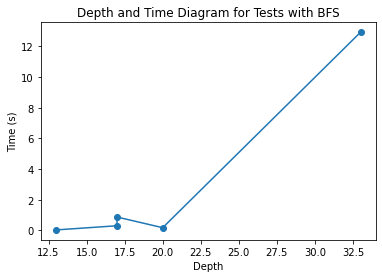

In [ ]:
depths = [13, 17, 17, 20, 33]
times = [0.0333, 0.3049, 0.8730, 0.1777, 12.9154]

plt.xlabel("Depth")
plt.ylabel("Time (s)")
plt.title("Depth and Time Diagram for Tests with BFS")

plt.plot(depths, times, '-o')
plt.show()

### IDS

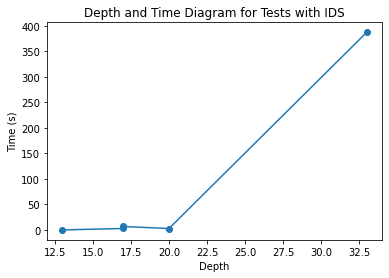

In [ ]:
depths = [13, 17, 17, 20, 33]
times = [0.2171, 3.0607, 6.9473, 2.9035, 387.1376]

plt.xlabel("Depth")
plt.ylabel("Time (s)")
plt.title("Depth and Time Diagram for Tests with IDS")

plt.plot(depths, times, '-o')
plt.show()

### A*

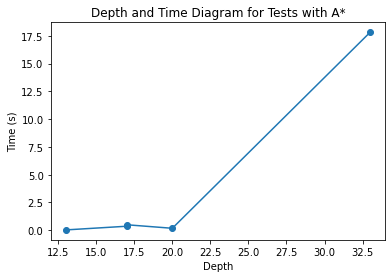

In [ ]:
depths = [13, 17, 17, 20, 33]
times = [0.0310, 0.3622, 0.4953, 0.1781, 17.8117]

plt.xlabel("Depth")
plt.ylabel("Time (s)")
plt.title("Depth and Time Diagram for Tests with A*")

plt.plot(depths, times, '-o')
plt.show()

## Conclusion
As we can see, BFS and IDS algorithms always find the optimal solution if path costs are equal to 1. Both BFS and IDS algorithms have time complexity of O($b^d$). IDS takes more time in comparison to BFS since It revisits some states on each iteration of algorithm on specified depth. On the other hand IDS only uses memory space of O(b.d) which is too much more efficient than BFS which uses O($b^d$) memory space. A* with an admissible and consistent heuristic always finds the optimal path in minimum steps. In all tests A* has expanded less states to find the optimal path. Due to optimality in all algorithms number of steps to reach the goal is equal to the optimal number of steps to reach the goal which is shown in tables.